<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you will teach network to use attention during captioning images.

Here is what we need to do:
1. Take pretrained Inception V3 to build feature vector for positions of images.
2. Stack LSTN with attention on top of that.
3. Train the model, draw attention maps.

This assignment is based on Alexander Panin's captioning assignment (https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework04/homework04_basic_part2_image_captioning.ipynb) and on the paper "Show, Attend and Tell" (https://arxiv.org/abs/1502.03044).

In [1]:
# Please eithrer download data from https://yadi.sk/d/KGh1SngBWH4stg
# or generate it manually with preprocess_data.

### Data preprocessing

In [1]:
#%%time
# Read Dataset
from torch.utils.data import Dataset
import numpy as np
import json
import os
from functools import lru_cache

class BigArray(Dataset):
    """
    This class memorizes the contents of the last accessed file of the big dataset,
    so it allows fast sequetial access to the rows of the dataset without RAM overusage.
    """
    def __init__(self, path):
        self.path = path
        self.files = sorted([f for f in os.listdir(path) if f.endswith('.npy')])
        self.file_sizes = [self.get_file_by_id(i).shape[0] for i in range(len(self.files))]
        self.size = sum(self.file_sizes)
        
        self.file_idx_mapping = []
        self.file_pos_mapping = []
        for i, file_size in enumerate(self.file_sizes):
            self.file_idx_mapping += [i] * file_size
            self.file_pos_mapping += list(range(file_size))
    
    def __len__(self):
        return self.size
    
    @lru_cache(maxsize=1)
    def get_file_by_id(self, idx):
        return np.load(os.path.join(self.path, self.files[idx]))
    
    def __getitem__(self, idx):
        file_idx = self.file_idx_mapping[idx]
        file_pos = self.file_pos_mapping[idx]
        return self.get_file_by_id(file_idx)[file_pos]
        
captions = json.load(open('./data/captions_tokenized.json'))
img_codes = BigArray('./data/image_codes_for_attn')

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [2]:
print("Each image code is a 2048-unit vector [ shape: %s x %s ]" % (str(len(img_codes)), str(img_codes[0].shape)))
print(img_codes[0][:3].round(5), end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: 118287 x (2048, 8, 8) ]
[[[0.      0.      0.      0.      0.      0.      0.      0.     ]
  [0.      0.      0.      0.      0.      0.      0.      0.     ]
  [0.      0.      0.      0.      0.32616 0.42296 0.      0.     ]
  [0.      0.      0.      0.      0.      0.      0.      0.     ]
  [0.      0.      0.      0.      0.55507 0.79336 0.      0.     ]
  [0.      0.      0.      0.      0.      0.      0.2207  0.47894]
  [0.      0.      0.      0.      0.      0.      0.      0.     ]
  [0.04249 0.      0.49726 0.      0.2512  0.      0.      0.14297]]

 [[0.      0.      0.      0.      0.      0.      0.      0.59245]
  [0.      0.      0.      0.      0.      0.      0.      0.     ]
  [0.18274 0.25888 0.      0.      0.      0.      0.      0.     ]
  [0.25187 0.      0.      0.      0.92649 0.8288  0.91266 0.43071]
  [0.      0.      0.      0.      0.25342 0.86897 0.      0.45675]
  [0.      0.      0.21421 1.08193 0.13428 

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [4]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
<YOUR CODE HERE>

In [5]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,  162,  199, 1957,   74,   35,   18,  769,   64,   27,    4,
         373, 1427,   14,    2],
       [   1,    4,   99,   21, 1957, 3275,  160,   63,  468,   30,   14,
           2,    3,    3,    3],
       [   1,  149, 1957,   35, 2001,    6,    4, 1556,  779,    2,    3,
           3,    3,    3,    3],
       [   1, 2445,  199, 1957,   35,    4, 1052,    9,    4, 1392, 1015,
          14,    2,    3,    3],
       [   1,   99,   21,  199, 1957,   35,    4, 1052, 1785,    2,    3,
           3,    3,    3,    3]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 



We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
class AttentionMap(nn.Module):
    """ A Layer which provides attention map for a query. """
    def __init__(self, query_dim, feature_dim, inner_dim=256):
        super().__init__()
        self.query_dim = query_dim
        self.feature_dim = feature_dim
        self.inner_dim = inner_dim
        # create layers which convert query and features into the same inner space
        <YOUR CODE>
    
    def forward(self, query, features):
        # compute attention map over features for the egiven queries
        # use scaled dot product (https://arxiv.org/abs/1706.03762)
        # in inner space as a similarity measure
        return <YOUR CODE>

In [10]:
dummy_img_vec = torch.randn(5, 2048, 64)
dummy_query = torch.randn(5, 512)

dummy_attention_map = AttentionMap(512, 2048).forward(dummy_query, dummy_img_vec)

assert dummy_attention_map.shape == (5, 64)

In [11]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = <YOUR CODE> 
            
        # attention: create attention over image spatial positions with previous
        # LSTM hidden state as a query
        self.attention_map = <YOUR CODE>
        
        # attention gate: create attention gate - a linear layer with one output neuron.
        # The output defines whether LSTM need context vector at the current step.
        # The input is the previous LSTM hidden state
        self.attn_gate = <YOUR CODE>
        
        # lstm: create a recurrent core of your network. Use LSTMCell
        self.lstm = <YOUR CODE>

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = <YOUR CODE> 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors.mean(2))
        initial_hid = self.cnn_to_h0(image_vectors.mean(2))
        
        # compute embeddings for captions_ix
        # captions_emb = <YOUR CODE>
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. use lstm state as an attention query, obtain attention map
        # 3. compute context vector using attention map and image vectors
        # 4. feed lstm state to attention gate linear layer, take sigmoid
        # 5. multiply context vector by the gate value
        # 6. feed lstm with captions concatenated with context vector
        # 7. compute logits for next token probabilities
        # 8. store and return attention map
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # attention_map should be attention map sequence of shape [batch, caption_length, width * height]
        # attention_gates should be attention gate sequence of shape [batch, caption_length]
        lstm_out = <YOUR_CODE>
        attention_map = <YOUR CODE>
        attention_gates = <YOUR CODE>
        
        # compute logits from lstm_out
        logits = <YOUR_CODE>
        
        return logits, attention_map, attention_gates

In [42]:
network = CaptionNet(n_tokens)

In [43]:
dummy_img_vec = torch.randn(len(captions[0]), 2048, 64)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits, dummy_attention_map, dummy_attention_gates = network.forward(dummy_img_vec, dummy_capt_ix)
dummy_logits, dummy_attention_map, dummy_attention_gates = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits shape:', dummy_logits.shape)
print('attention map shape:', dummy_attention_map.shape)
print('attention gates shape:', dummy_attention_gates.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)
assert dummy_attention_map.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], 64)
assert dummy_attention_gates.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1])

logits shape: torch.Size([5, 31, 10403])
attention map shape: torch.Size([5, 31, 64])
attention gates shape: torch.Size([5, 31])


In [44]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus 
              attention regularizer. Scalar float tensor
    """
    
    if next(network.parameters()).is_cuda:
        image_vectors, captions_ix = image_vectors.cuda(), captions_ix.cuda()
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next, attention_map, attention_gates = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = <YOUR CODE>
    
    # compute the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    # regularizer = ((1 - (attention_map * (captions_ix_inp != pad_ix)[:, :, None].float()).sum(1)) ** 2).mean()
    mask = (captions_ix_inp != pad_ix)
    masked_attention_map = attention_map * mask[:, :, None].float()
    regularizer = ((mask.sum(1)[:, None].float() / 64 - masked_attention_map.sum(1)) ** 2).mean()
    
    return loss + regularizer

In [45]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [46]:
<YOUR CODE>

# Training

* First make train/val split without extra memory usage
* Implement the batch generator
* Than train the network as usual

In [47]:
class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx
    
    def __len__(self):
        return len(self.idx)
        
    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [48]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_idx, val_img_idx = train_test_split(np.arange(len(img_codes), dtype='int'),
                                              test_size=0.1,
                                              random_state=42)
train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_codes, train_img_idx)
val_img_codes = IdxDataset(img_codes, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

In [49]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample sequential numbers for image/caption indicies
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0
    
    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [50]:
generate_batch(img_codes, captions, 3)

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.1430],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1428,  0.3984,  0.4926],
          [ 0.3575,  0.4978,  0.7956,  ...,  0.3993,  0.1763,  0.0000],
          [ 0.2861,  0.6393,  1.1303,  ...,  0.3328,  0.1544,  0.2204]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.1454,  1.4907],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0457,  0.2365],
          ...,
          [ 0.1418,  0.0272,  0.0000,  ...,  0.0000,  0.0000,  0.0511],
          [ 0.1816,  0.4290,  1.0488,  ...,  0.4481,  0.6278,  0.4753],
          [ 0.4624,  0.4928,  0.0255,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.2551,  0.0000,  0.0000],
          [ 0.4769,  0.3957,

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0

In [51]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [52]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()
   
    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
            # clear old gradients; do a backward pass to get new gradients; then train with opt
            <YOUR CODE>
        
            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch
        
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches
    
    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 50/50 [00:14<00:00,  3.56it/s]



Epoch: 0, train loss: 5.857342805862427, val loss: 4.911153030395508


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]



Epoch: 1, train loss: 4.829776210784912, val loss: 4.606118202209473


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]



Epoch: 2, train loss: 4.553761787414551, val loss: 4.354851627349854


100%|██████████| 50/50 [00:14<00:00,  1.65it/s]



Epoch: 3, train loss: 4.340541157722473, val loss: 4.262469387054443


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 4, train loss: 4.1993479871749875, val loss: 4.081993770599365


100%|██████████| 50/50 [00:14<00:00,  1.64it/s]



Epoch: 5, train loss: 4.093230233192444, val loss: 4.001516199111938


100%|██████████| 50/50 [00:14<00:00,  1.61it/s]



Epoch: 6, train loss: 4.0008087682724, val loss: 3.979095697402954


100%|██████████| 50/50 [00:14<00:00,  1.61it/s]



Epoch: 7, train loss: 3.8652125215530395, val loss: 3.884168100357056


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 8, train loss: 3.8290667581558226, val loss: 3.771008586883545


100%|██████████| 50/50 [00:14<00:00,  1.65it/s]



Epoch: 9, train loss: 3.728066391944885, val loss: 3.66172194480896


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



Epoch: 10, train loss: 3.691632876396179, val loss: 3.5835886001586914


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]



Epoch: 11, train loss: 3.636599907875061, val loss: 3.501324939727783


100%|██████████| 50/50 [00:14<00:00,  8.96it/s]



Epoch: 12, train loss: 3.555649642944336, val loss: 3.7419545650482178


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 13, train loss: 3.447819571495056, val loss: 3.4152997970581054


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]



Epoch: 14, train loss: 3.4595813179016113, val loss: 3.4029290199279787


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 15, train loss: 3.4098169565200807, val loss: 3.519616651535034


100%|██████████| 50/50 [00:14<00:00,  1.60it/s]



Epoch: 16, train loss: 3.406359076499939, val loss: 3.334983158111572


100%|██████████| 50/50 [00:12<00:00,  8.27it/s]



Epoch: 17, train loss: 3.3086459684371947, val loss: 3.329507827758789


100%|██████████| 50/50 [00:14<00:00,  9.33it/s]



Epoch: 18, train loss: 3.3744983148574828, val loss: 3.292890691757202


100%|██████████| 50/50 [00:14<00:00,  8.90it/s]



Epoch: 19, train loss: 3.2741830587387084, val loss: 3.218711280822754


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 20, train loss: 3.2479441928863526, val loss: 3.3140504360198975


100%|██████████| 50/50 [00:14<00:00,  9.67it/s]



Epoch: 21, train loss: 3.2101423263549806, val loss: 3.2090381145477296


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]



Epoch: 22, train loss: 3.1890222930908205, val loss: 3.219196605682373


100%|██████████| 50/50 [00:14<00:00,  8.34it/s]



Epoch: 23, train loss: 3.21110267162323, val loss: 3.152960920333862


100%|██████████| 50/50 [00:14<00:00,  9.14it/s]



Epoch: 24, train loss: 3.152790460586548, val loss: 3.0407037258148195


100%|██████████| 50/50 [00:14<00:00,  8.98it/s]



Epoch: 25, train loss: 3.1620741844177247, val loss: 3.1596453189849854


100%|██████████| 50/50 [00:14<00:00,  9.40it/s]



Epoch: 26, train loss: 3.112562437057495, val loss: 3.1588400840759276


100%|██████████| 50/50 [00:14<00:00,  9.02it/s]



Epoch: 27, train loss: 3.092358989715576, val loss: 3.0992764949798586


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]



Epoch: 28, train loss: 3.0708746099472046, val loss: 2.977894115447998


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 29, train loss: 3.0590311813354494, val loss: 3.0341241359710693


100%|██████████| 50/50 [00:14<00:00,  8.18it/s]



Epoch: 30, train loss: 3.1857529401779177, val loss: 3.068205547332764


100%|██████████| 50/50 [00:14<00:00,  8.38it/s]



Epoch: 31, train loss: 3.077674250602722, val loss: 2.98830132484436


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]



Epoch: 32, train loss: 3.0114508390426638, val loss: 3.1675366878509523


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 33, train loss: 2.9921828603744505, val loss: 3.1170061588287354


100%|██████████| 50/50 [00:14<00:00,  7.09it/s]



Epoch: 34, train loss: 3.0451382637023925, val loss: 3.0349524974823


100%|██████████| 50/50 [00:14<00:00,  7.02it/s]



Epoch: 35, train loss: 2.985067834854126, val loss: 2.8707737922668457


100%|██████████| 50/50 [00:14<00:00,  7.00it/s]



Epoch: 36, train loss: 3.0223535966873167, val loss: 2.8856256008148193


100%|██████████| 50/50 [00:14<00:00,  7.16it/s]



Epoch: 37, train loss: 2.956374931335449, val loss: 2.9126633167266847


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]



Epoch: 38, train loss: 2.976674838066101, val loss: 3.0233747959136963


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]



Epoch: 39, train loss: 2.970353851318359, val loss: 3.0054273128509523


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]



Epoch: 40, train loss: 2.9241756439208983, val loss: 3.0616972923278807


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]



Epoch: 41, train loss: 2.935698685646057, val loss: 2.926966428756714


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]



Epoch: 42, train loss: 2.897621054649353, val loss: 2.865610647201538


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]



Epoch: 43, train loss: 2.958058543205261, val loss: 2.961677837371826


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]



Epoch: 44, train loss: 2.90505943775177, val loss: 2.8989408016204834


100%|██████████| 50/50 [00:13<00:00,  3.58it/s]



Epoch: 45, train loss: 2.8896990394592286, val loss: 2.853977823257446


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]



Epoch: 46, train loss: 2.913361449241638, val loss: 2.8042388916015626


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]



Epoch: 47, train loss: 2.846775884628296, val loss: 2.971636152267456


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 48, train loss: 2.905002069473267, val loss: 2.7384352684020996


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]



Epoch: 49, train loss: 2.8390262937545776, val loss: 2.8412056446075438


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 50, train loss: 2.854212441444397, val loss: 2.823766279220581


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 51, train loss: 2.8830878019332884, val loss: 2.809809923171997


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]



Epoch: 52, train loss: 2.861769142150879, val loss: 2.8487339496612547


100%|██████████| 50/50 [00:15<00:00,  2.52it/s]



Epoch: 53, train loss: 2.8552671241760255, val loss: 2.8268220901489256


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]



Epoch: 54, train loss: 2.861844120025635, val loss: 2.9591884136199953


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]



Epoch: 55, train loss: 2.8418259620666504, val loss: 2.8842734336853026


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 56, train loss: 2.8044909954071047, val loss: 2.703621530532837


100%|██████████| 50/50 [00:14<00:00,  2.93it/s]



Epoch: 57, train loss: 2.829465250968933, val loss: 2.8357612609863283


100%|██████████| 50/50 [00:14<00:00,  2.76it/s]



Epoch: 58, train loss: 2.836371283531189, val loss: 2.775577163696289


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]



Epoch: 59, train loss: 2.8313494539260864, val loss: 3.0453155040740967


100%|██████████| 50/50 [00:14<00:00,  2.16it/s]



Epoch: 60, train loss: 2.8600622415542603, val loss: 2.8049301147460937


100%|██████████| 50/50 [00:14<00:00,  2.23it/s]



Epoch: 61, train loss: 2.7865591049194336, val loss: 2.6893083095550536


100%|██████████| 50/50 [00:14<00:00,  2.29it/s]



Epoch: 62, train loss: 2.7873573017120363, val loss: 2.862777853012085


100%|██████████| 50/50 [00:14<00:00,  2.94it/s]



Epoch: 63, train loss: 2.7844695615768433, val loss: 2.727318620681763


100%|██████████| 50/50 [00:14<00:00,  2.25it/s]



Epoch: 64, train loss: 2.7577590274810793, val loss: 2.8772388458251954


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



Epoch: 65, train loss: 2.809587211608887, val loss: 2.8140538215637205


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]



Epoch: 66, train loss: 2.776010332107544, val loss: 2.763665866851807


100%|██████████| 50/50 [00:14<00:00,  2.16it/s]



Epoch: 67, train loss: 2.7858537244796753, val loss: 2.785137939453125


100%|██████████| 50/50 [00:14<00:00,  2.21it/s]



Epoch: 68, train loss: 2.780336971282959, val loss: 2.646882486343384


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 69, train loss: 2.7482009315490723, val loss: 2.8228639125823975


100%|██████████| 50/50 [00:14<00:00,  2.25it/s]



Epoch: 70, train loss: 2.7816517162323, val loss: 2.8487184047698975


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]



Epoch: 71, train loss: 2.74758572101593, val loss: 2.880219554901123


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]



Epoch: 72, train loss: 2.761275863647461, val loss: 2.7515026569366454


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



Epoch: 73, train loss: 2.81686101436615, val loss: 2.778673696517944


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]



Epoch: 74, train loss: 2.7183944177627564, val loss: 2.950005626678467


100%|██████████| 50/50 [00:16<00:00,  1.30it/s]



Epoch: 75, train loss: 2.7386756563186645, val loss: 2.680144214630127


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 76, train loss: 2.7621214389801025, val loss: 2.668373394012451


100%|██████████| 50/50 [00:17<00:00,  1.25it/s]



Epoch: 77, train loss: 2.776383190155029, val loss: 2.7845998764038087


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Epoch: 78, train loss: 2.7206386804580687, val loss: 2.7724188804626464


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]



Epoch: 79, train loss: 2.689666872024536, val loss: 2.8503880977630613


100%|██████████| 50/50 [00:15<00:00,  8.12it/s]



Epoch: 80, train loss: 2.6973950719833373, val loss: 2.8000739097595213


100%|██████████| 50/50 [00:26<00:00,  1.06it/s]



Epoch: 81, train loss: 2.7315050315856935, val loss: 2.7825075149536134


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 82, train loss: 2.6691014051437376, val loss: 2.641878128051758


100%|██████████| 50/50 [00:19<00:00,  8.17it/s]



Epoch: 83, train loss: 2.7157835578918457, val loss: 2.628199052810669


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 84, train loss: 2.7020578527450563, val loss: 2.6880093574523927


100%|██████████| 50/50 [00:13<00:00,  6.66it/s]



Epoch: 85, train loss: 2.716742181777954, val loss: 2.576378679275513


100%|██████████| 50/50 [00:12<00:00,  4.63it/s]



Epoch: 86, train loss: 2.6947953653335572, val loss: 2.779227590560913


100%|██████████| 50/50 [00:09<00:00,  8.14it/s]



Epoch: 87, train loss: 2.684785580635071, val loss: 2.8298028469085694


100%|██████████| 50/50 [00:06<00:00,  7.38it/s]



Epoch: 88, train loss: 2.7114501714706423, val loss: 2.6324665546417236


100%|██████████| 50/50 [00:11<00:00,  4.69it/s]



Epoch: 89, train loss: 2.6977279949188233, val loss: 2.6416945457458496


100%|██████████| 50/50 [00:12<00:00,  5.35it/s]



Epoch: 90, train loss: 2.639830050468445, val loss: 2.764047956466675


100%|██████████| 50/50 [00:13<00:00,  4.98it/s]



Epoch: 91, train loss: 2.6825830841064455, val loss: 2.5695278644561768


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



Epoch: 92, train loss: 2.668424301147461, val loss: 2.6806265354156493


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



Epoch: 93, train loss: 2.65630081653595, val loss: 2.6910545349121096


100%|██████████| 50/50 [00:14<00:00,  4.85it/s]



Epoch: 94, train loss: 2.6952938556671144, val loss: 2.627184438705444


100%|██████████| 50/50 [00:14<00:00,  5.08it/s]



Epoch: 95, train loss: 2.6866621160507203, val loss: 2.696855401992798


100%|██████████| 50/50 [00:16<00:00,  3.85it/s]



Epoch: 96, train loss: 2.696608991622925, val loss: 2.6493139266967773


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]



Epoch: 97, train loss: 2.6394561624526975, val loss: 2.5720465183258057


100%|██████████| 50/50 [00:15<00:00,  4.39it/s]



Epoch: 98, train loss: 2.652028818130493, val loss: 2.615417957305908


100%|██████████| 50/50 [00:15<00:00,  3.77it/s]



Epoch: 99, train loss: 2.6601226329803467, val loss: 2.615422010421753
Finished!


In [53]:
torch.save(network.state_dict(), 'good_network.pth')

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [32]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [33]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    attention_maps = []
    attention_gates = []
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_vector = vectors_8x8.view(vectors_8x8.shape[0], vectors_8x8.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_vector, prefix_ix = input_vector.cuda(), prefix_ix.cuda()
        next_word_logits, cur_attention_map, cur_attention_gate = network.forward(input_vector, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        cur_attention_map = cur_attention_map[0, -1]
        cur_attention_gate = cur_attention_gate[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        attention_maps.append(cur_attention_map.detach().cpu())
        attention_gates.append(cur_attention_gate.detach().cpu())
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix, attention_maps, attention_gates

In [70]:
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline

#sample image
!mkdir -p data
!wget "https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg" -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299), mode='wrap').astype('float32')

--2019-04-21 23:19:43--  https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg
Resolving thecenterformindfuleating.org (thecenterformindfuleating.org)... 34.226.77.200
Connecting to thecenterformindfuleating.org (thecenterformindfuleating.org)|34.226.77.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121275 (118K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 118,43K   253KB/s    in 0,5s    

Last-modified header invalid -- time-stamp ignored.
2019-04-21 23:19:45 (253 KB/s) - ‘data/img.jpg’ saved [121275/121275]



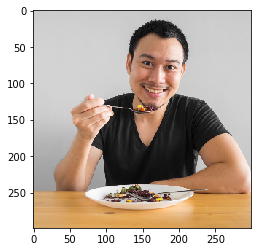

In [71]:
plt.imshow(img)

In [56]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[0][1:-1]))

a man with a piece of cake with a large knife and a drink .
a man with a glass of wine glasses and a wine glass .
a man with a knife and a knife eating a piece of cake .
a man is eating a slice of cake .
a man and a woman sitting at a table with a slice of cake .
a man eating a piece of cake with a fork and a knife .
a man is eating a slice of cake .
a man with a glass of wine glasses and a glass of wine .
a man with a glass of wine glasses and a wine glass
a man with a glass of wine glasses and a wine glass


In [74]:
def draw_attention_map(img, caption, attention_map, attention_gates):
    s = 4
    n = len(caption)
    w = 4
    h = n // w + 1
    plt.figure(figsize=(w * s, h * s))
    plt.subplot(h, w, 1)
    plt.imshow(img)
    plt.title('INPUT', fontsize=s * 4)
    plt.axis('off')
    for i, word, attention, gate in zip(range(n), caption, attention_map, attention_gates):
        plt.subplot(h, w, 2 + i)
        attn_map = attention.view(1, 1, 8, 8)
        attn_map = F.interpolate(attn_map, size=(12, 12), mode='nearest')
        attn_map = F.interpolate(attn_map, size=(299, 299), mode='bilinear', align_corners=False)
        attn_map = attn_map[0, 0][:, :, None]
        attn_map = torch.min(attn_map / attn_map.max(), torch.ones_like(attn_map))
        plt.imshow(img * attn_map)
        plt.title(word + '[%.02f]' % gate, fontsize=s * 4)
        plt.axis('off')

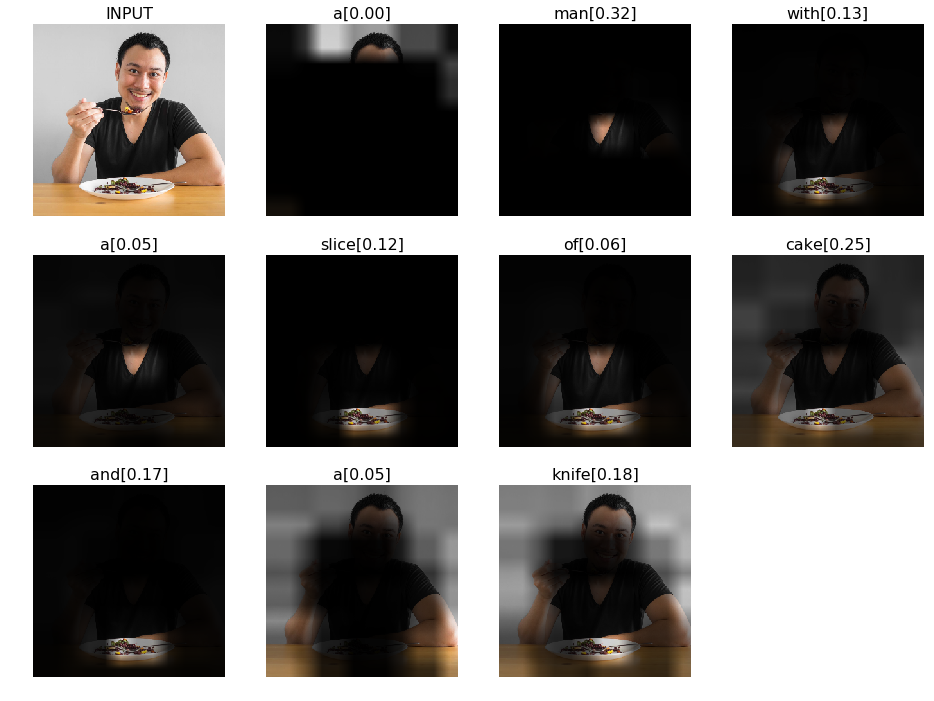

In [77]:
c, am, g = generate_caption(img, t=5.)
draw_attention_map(img, c[1:-1], am, g)

--2019-04-21 23:21:28--  https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg
Resolving www.dimensioneattiva.it (www.dimensioneattiva.it)... 185.81.2.104
Connecting to www.dimensioneattiva.it (www.dimensioneattiva.it)|185.81.2.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122995 (120K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 120,11K   509KB/s    in 0,2s    

2019-04-21 23:21:29 (509 KB/s) - ‘data/img.jpg’ saved [122995/122995]



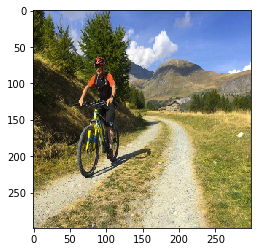

a bike parked on the side of a road .
a bike is parked next to a tree .
a bike is parked in a field near a tree .
a bike is parked in the grass near a tree .
a bike parked next to a tree in a field .
a bike is parked on the side of a road .
a bike parked on a road with a tree in the background .
a bike is parked on the side of the road .
a bike is parked on the side of the road .
a bike parked next to a tree in a grassy area .


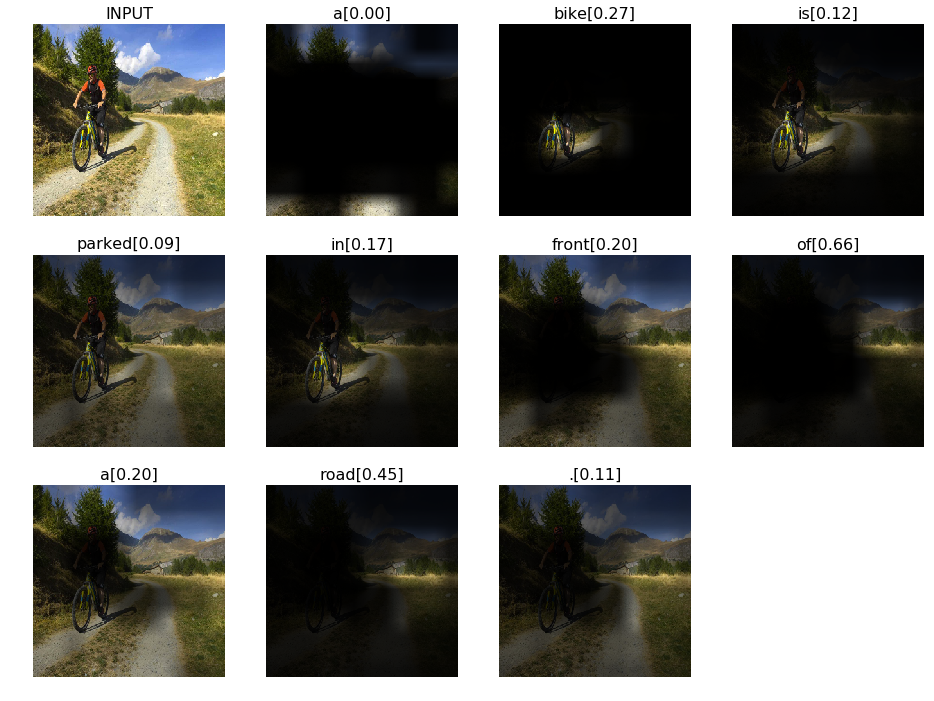

In [78]:
!wget https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299), mode='wrap').astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[0][1:-1]))

c, am, g = generate_caption(img, t=5.)
draw_attention_map(img, c[1:-1], am, g)

--2019-04-21 23:23:50--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K  --.-KB/s    in 0,1s    

2019-04-21 23:23:50 (783 KB/s) - ‘data/img.jpg’ saved [106870/106870]



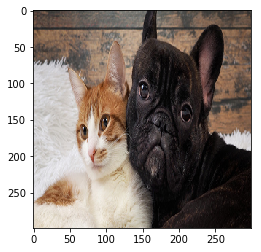

a black and white cat sitting on a bed .
a black and white cat sitting on a couch .
a black and white cat sitting on a couch .
a black cat laying on a couch with a remote control .
a black and white cat laying on a bed .
a black and white cat sitting on a couch .
a black and white cat sitting on a couch .
a black and white cat laying on a bed .
a black and white cat sitting on a couch .
a black and white cat laying on a couch .


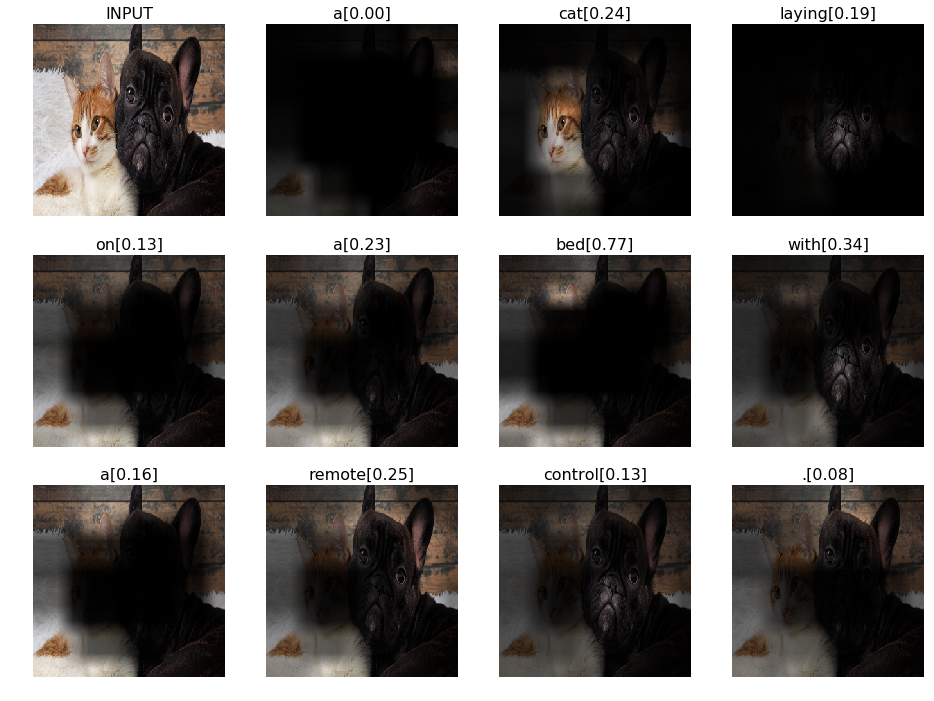

In [83]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299), mode='wrap').astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[0][1:-1]))

c, am, g = generate_caption(img, t=5.)
draw_attention_map(img, c[1:-1], am, g)

--2019-04-21 23:24:44--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.188.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.188.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105,40K   152KB/s    in 0,7s    

2019-04-21 23:24:47 (152 KB/s) - ‘data/img.jpg’ saved [107928/107928]



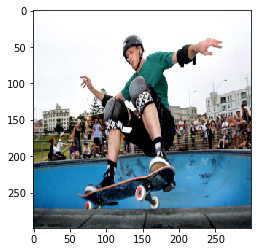

a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard in the air
a man riding a skateboard on a skateboard .
a man riding a skateboard in a skate park
a man riding a skateboard on a skateboard .
a man riding a skateboard in the air .
a man riding a skateboard on a skateboard .


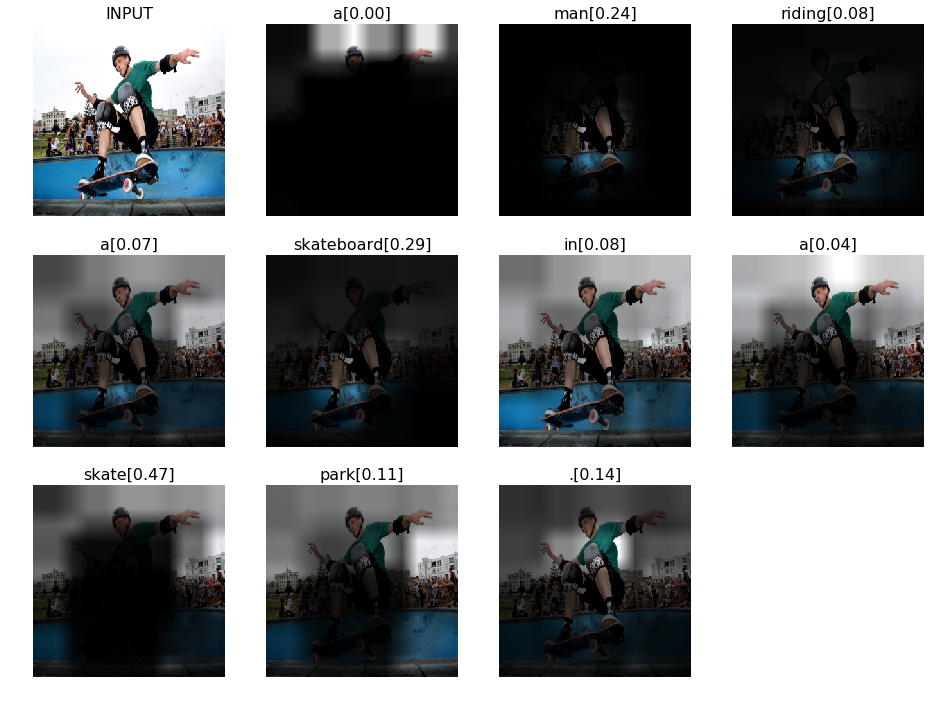

In [84]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299), mode='wrap').astype('float32')

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[0][1:-1]))

c, am, g = generate_caption(img, t=5.)
draw_attention_map(img, c[1:-1], am, g)

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [ ]:
#apply your network on image sample you found
#
#

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563